# Style Transfer with Deep Neural Networks


In this notebook, we’ll create a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) using PyTorch.

In this paper, VGG-19 network is being used for the purpose of Style Transfer. VGG-19 comprises of a series of convolutional and pooling layers.


### Separating Style and Content

An Image consisites of 2 parts, Style and Content.Style transfer method relies completely on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. Then we will compute the content and style losses and use gradient descent to optimize the process.

In [0]:
# importing resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

## Load in Model (VGG-19)

As we don't need the `classifier` portion, we only take the `features` portion, which we're going to load in and "freeze" the weights of/

In [0]:
# Get the "features" portion of VGG19
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters.
for param in vgg.parameters():
    param.requires_grad_(False)


In [3]:
#Lets have a look at the VGG "features"
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [4]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Load in Content and Style Images

The `load_image` function loads and converts images to normalized Tensors.

Additionally, it will be easier to have smaller images and to squish the content and style images so that they are of the same size.

In [0]:
def load_image(img_path, max_size=600, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

As i used Google Colab for this, you need to mount the drive and import the files. Skip this step if using local machine or other service.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!ls "/content/drive/My Drive/images"

ben_passmore.jpg  dusk3.jpg    kahlo.jpg     octopus.jpg       wave.jpg
cat.jpg		  dusk.png     kitten.jpg    sotomayor.jpg
delaunay.jpg	  hockney.jpg  magritte.jpg  space_needle.jpg
dusk2.jpg	  janelle.png  octavia.jpg   spaceNeedle.jpg


In [0]:
# load in content and style image
content = load_image('/content/drive/My Drive/images/cat.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/content/drive/My Drive/images/wave.jpg', shape=content.shape[-2:]).to(device)

In [0]:
# 'im_convert' function for un-normalizing an image and converting it to Numpy for displaying. 
def im_convert(tensor):
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

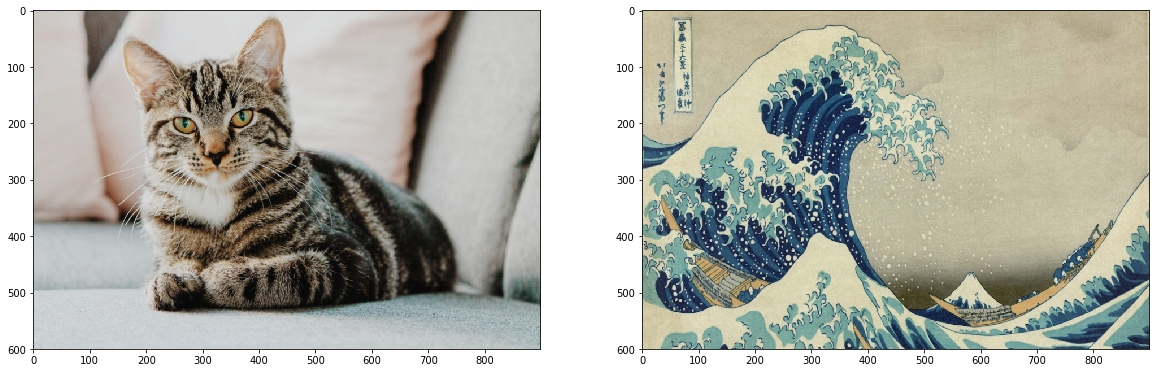

In [11]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

## Content and Style Features


In [0]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    # Mapping the layer names of PyTorch's VGGNet to names acoording to the paper
    #We only need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  #This layer is for content representation
                  '28': 'conv5_1'}
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). We need to calculate the Gram Matrix to get proper relations between the layers.

In [0]:
def gram_matrix(tensor):
    
    _, d, h, w = tensor.size()
    
    # Reshaping so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # Calculating the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Putting it all Together

Now that we've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! We'll extract our features from our images and calculate the gram matrices for each layer in our style representation.

In [0]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Individual Layer Style Weights

We can assign different weights to diffferent style layers. Weighing the earlier layers more, we get larger style artifacts in our target, and if we weight the later layers more we put more emphasis on later layers.
Here I have weighed the initial layers more to get bigger elements from our Great Wave image.!

#### Content and Style Weight

Just like in the paper, we define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how stylized your final image is.

In [0]:
# weights for each style layer 
#Just remember, don't assign weight to conv4_2(content layer)
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.775,
                 'conv3_1': 0.55,
                 'conv4_1': 0.325,
                 'conv5_1': 0.1}

content_weight = 1  # alpha
style_weight = 1e4  # beta

## Updating the Target & Calculating Losses

Here we have to optimize our target by calculating and using our losses.
Total Loss= Style Loss + Content Loss
Content loss is calculated by taking mean of square of difference of content layers in our original and target images as per Paper.
Style Loss is calculated by taking mean of square of difference of style_grams calculated as per Paper.

Here I use the ADAM optimizer with learning rate of 0.1.

Total loss:  37029.92578125


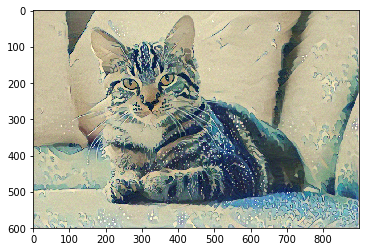

Total loss:  2589.5537109375


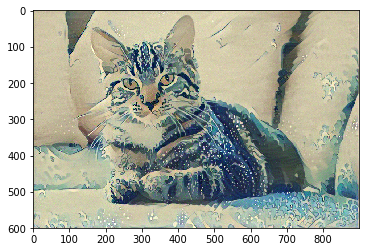

Total loss:  2332.57275390625


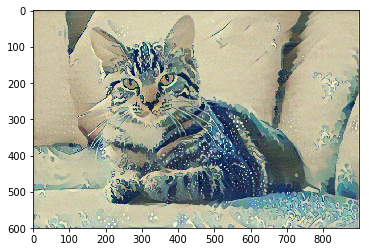

Total loss:  4572.73046875


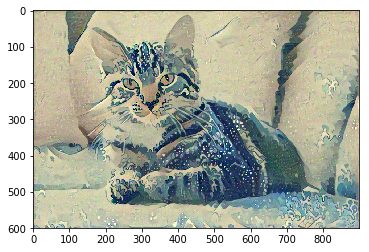

Total loss:  2260.51171875


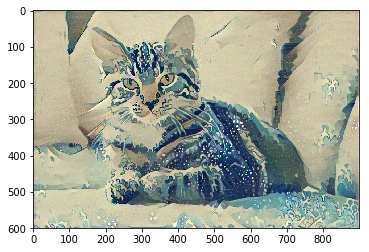

Total loss:  2777.8388671875


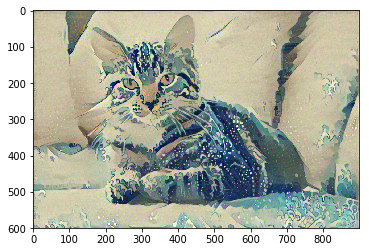

Total loss:  2887.975830078125


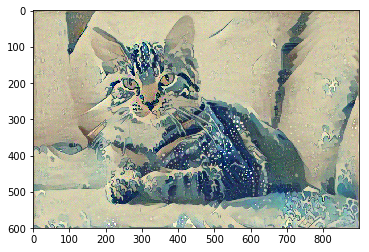

Total loss:  1789.9573974609375


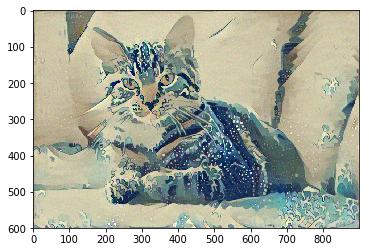

Total loss:  2400.71826171875


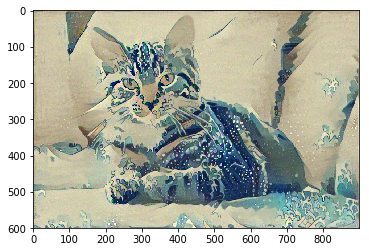

Total loss:  2323.6669921875


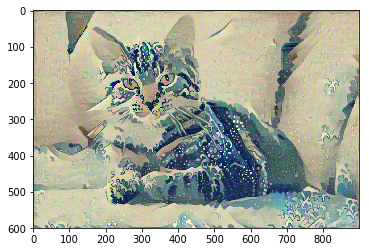

In [19]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.1)
steps = 4000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = get_features(target, vgg)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    style_loss = 0
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Final Result

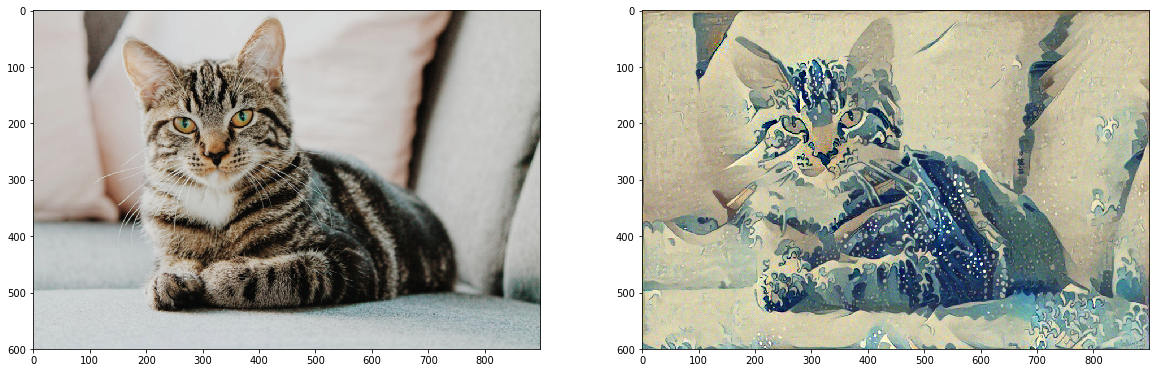

In [20]:
# display content and final, target image
fig, (ax1,ax3) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax3.imshow(im_convert(target))

## Final Words

Though its not the best, but I believe its a good start. we can tune our hyperparametes like Weights of content and style layers for preferred results.